In [1]:
import pandas as pd
import re

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
data_path = '/content/gdrive/My Drive/My Projects/Sentiment Analysis Twitter/train.csv'

In [4]:
data = pd.read_csv(data_path, encoding = "ISO-8859-1")
data.head(5)

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...


In [5]:
len(data)

99989

## Data Preprocessing

In [6]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

ps = PorterStemmer()

In [7]:
def Preprocessing(text):
    # stripping quotes at end of text
    text=text.strip('')

    # removing twitter handles @user
    text=re.sub("@[\w]*"," ",text)

    # removing URLs with the space
    text = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' ', text)

    # stripping space, " and ' from text
    text = text.strip(' "\'')

    # removing repeated letters of string such as yessss to yes 
    text=re.sub(r'(.)\1{3,}', r'\1', text)

    # removing the special characters
    text = re.sub('[^A-Za-z]', ' ', text)

    # replacing two or more dots with space
    text = re.sub("\\.{2,}"," ",text)

    # converting all text into small letters and storing them as words for further processing
    text_list = text.lower().split()

    # stemming the words (removing prefix and postfix) using Porter Stemming algorithm..
    text_list = [ps.stem(word) for word in text_list]
    
    return ' '.join(text_list)

In [8]:
data['Preprocessed_data']=data['SentimentText'].apply(Preprocessing)

In [9]:
data.head()

,ItemID,Sentiment,SentimentText,Preprocessed_data
0,1,0,is so sad for my APL frie...,is so sad for my apl friend
1,2,0,I missed the New Moon trail...,i miss the new moon trailer
2,3,1,omg its already 7:30 :O,omg it alreadi o
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...,omgaga im sooo im gunna cri i ve been at thi d...
4,5,0,i think mi bf is cheating on me!!! ...,i think mi bf is cheat on me t t


# Splitting the data

In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.20)

In [11]:
len(train), len(test)

(79991, 19998)

# Vectorization

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

count_vectorization = CountVectorizer()
tfidf_transformation = TfidfTransformer()

In [13]:
X_train_count_vector = count_vectorization.fit_transform(train["Preprocessed_data"])
X_train_tfidf_vector = tfidf_transformation.fit_transform(X_train_count_vector)

X_test_count_vector = count_vectorization.transform(test["Preprocessed_data"])
X_test_tfidf_vector = tfidf_transformation.transform(X_test_count_vector)

y_train = train['Sentiment']
y_test = test['Sentiment']

# Training and Testing Models

In [23]:
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [26]:
model_prediction = dict()

In [27]:
# SVM - Stochastic Gradient Descent
model = SGDClassifier(max_iter=1000, tol=1e-3, loss="modified_huber").fit(X_train_tfidf_vector, y_train)
model_prediction['SVM-SGD'] = model.predict(X_test_tfidf_vector)

# Multinomial Naive Bayes
model = MultinomialNB().fit(X_train_tfidf_vector, y_train)
model_prediction['Multinomial'] = model.predict(X_test_tfidf_vector)

# Bernoulli Naive Bayes
model = BernoulliNB().fit(X_train_tfidf_vector, y_train)
model_prediction['Bernoulli'] = model.predict(X_test_tfidf_vector)

# Logistic Regression
model = LogisticRegression(C=1).fit(X_train_tfidf_vector, y_train)
model_prediction['Logistic'] = model.predict(X_test_tfidf_vector)

# SVM - Support Vector Classifier
model = SVC(gamma='auto', C=1).fit(X_train_tfidf_vector, y_train)
model_prediction['SVM'] = model.predict(X_test_tfidf_vector)

# Decision Trees
model = DecisionTreeClassifier().fit(X_train_tfidf_vector, y_train)
model_prediction['Decision Tree'] = model.predict(X_test_tfidf_vector)

In [34]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [41]:
print("ACCURACY SCORE:\n")
for model_name in model_prediction.keys():
  print(model_name, ': ', round(accuracy_score(y_test, model_prediction[model_name])*100, 2))

ACCURACY SCORE:

SVM-SGD :  76.28
Multinomial :  74.01
Bernoulli :  74.33
Logistic :  76.47
SVM :  56.18
Decision Tree :  68.15


In [42]:
print("F1 SCORE:\n")
for model_name in model_prediction.keys():
  print(model_name, ': ', round(f1_score(y_test, model_prediction[model_name]), 2))

F1 SCORE:

SVM-SGD :  0.8
Multinomial :  0.79
Bernoulli :  0.78
Logistic :  0.8
SVM :  0.72
Decision Tree :  0.72


# Model Evaluation

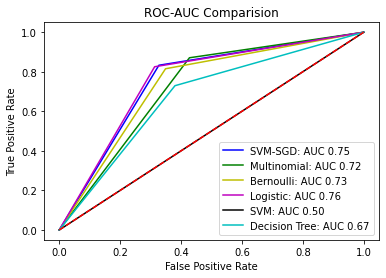

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

count = 0
colors = ['b', 'g', 'y', 'm', 'k', 'c']
for model, prediction in model_prediction.items():
    fpr, tpr, threshold = roc_curve(y_test, prediction)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, colors[count], label='%s: AUC %0.2f'% (model, roc_auc))
    count += 1

plt.title('ROC-AUC Comparision')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Doing further analysis on best model, i.e. Logistic Regression

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid)
grid.fit(X_train_tfidf_vector, y_train)

In [48]:
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameter: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

Best cross-validation score: 0.77
Best parameter:  {'C': 1}
Best estimator:  LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


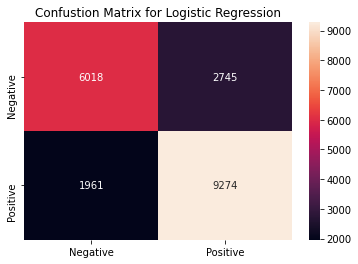

In [50]:
# Confusion Matrix for Logistic Regression
import seaborn as sns

conf_mat = confusion_matrix(y_test, model_prediction['Logistic'])
axes = ["Negative", "Positive"]
confusion_matrix_df = pd.DataFrame(conf_mat, axes, axes, dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("Confustion Matrix for Logistic Regression")
plt.show()